# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.rcParams['figure.figsize'] = 22, 10

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
%config Completer.use_jedi = False

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
df = pd.read_csv('fb_close.csv', index_col=[0], parse_dates=[0])
df.head()

,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999


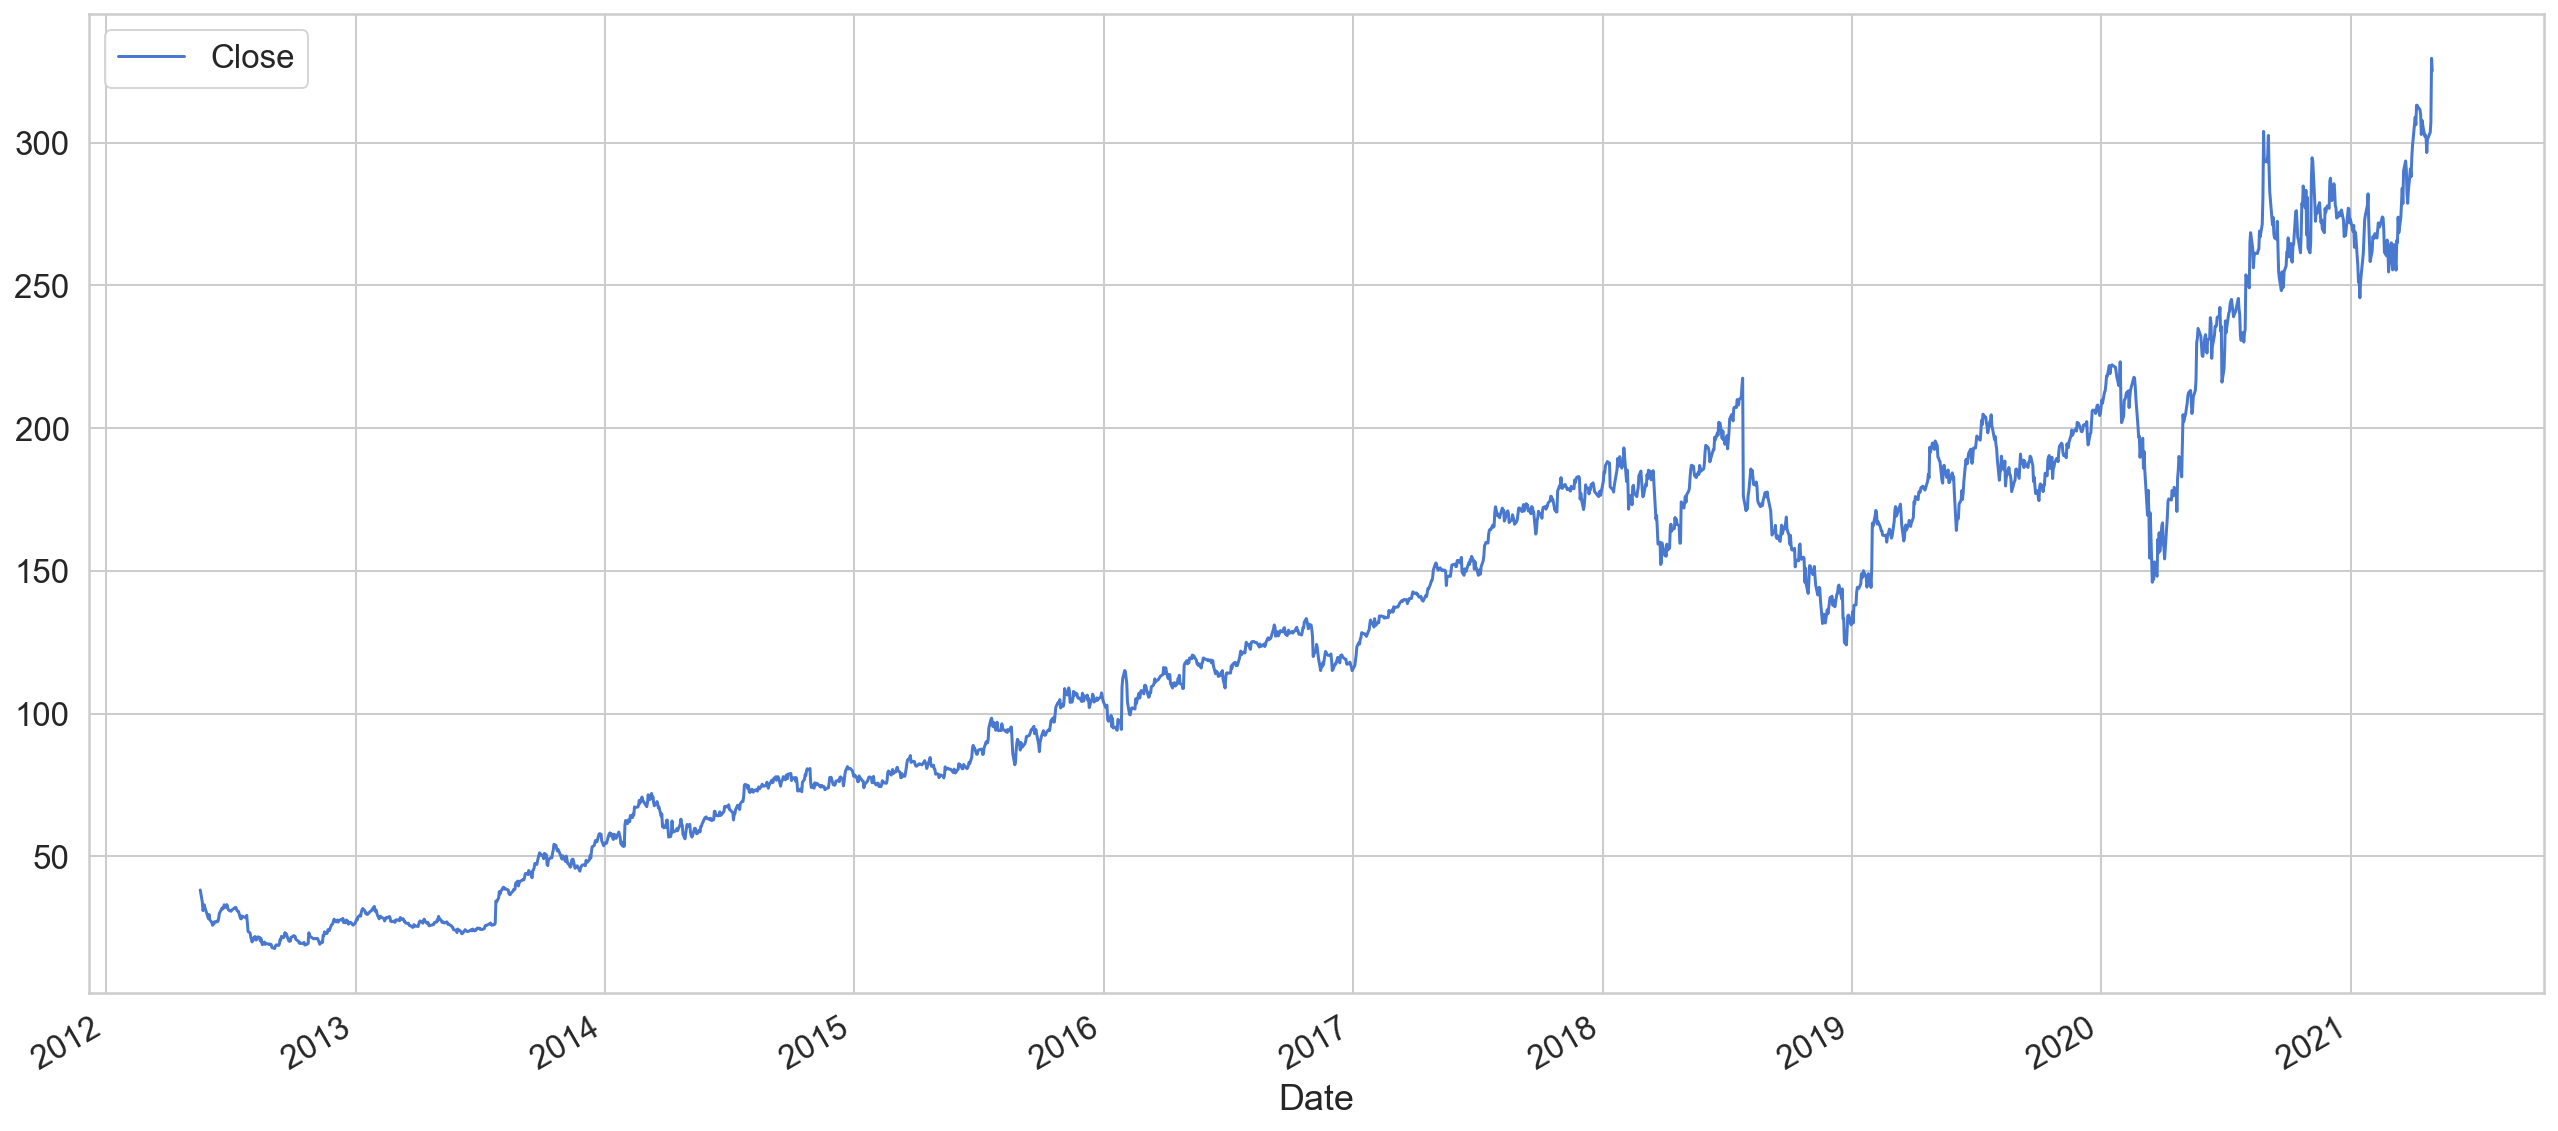

In [7]:
df.plot()
plt.show()

In [8]:
df['Avg'] = df['Close'].rolling(7, min_periods=1, center=True).mean()
df.head(10)

,Close,Avg
Date,,
2012-05-18,38.230000,33.815000
2012-05-21,34.029999,33.657999
2012-05-22,31.000000,33.366666
2012-05-23,32.000000,32.720000
2012-05-24,33.029999,31.285714
2012-05-25,31.910000,30.652857
2012-05-29,28.840000,30.184286
2012-05-30,28.190001,29.455714
2012-05-31,29.600000,28.432857


In [9]:
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['dayOfWeek'] = df.index.dayofweek.map(day_dict)
df.head(10)

,Close,Avg,dayOfWeek
Date,,,
2012-05-18,38.230000,33.815000,Friday
2012-05-21,34.029999,33.657999,Monday
2012-05-22,31.000000,33.366666,Tuesday
2012-05-23,32.000000,32.720000,Wednesday
2012-05-24,33.029999,31.285714,Thursday
2012-05-25,31.910000,30.652857,Friday
2012-05-29,28.840000,30.184286,Tuesday
2012-05-30,28.190001,29.455714,Wednesday
2012-05-31,29.600000,28.432857,Thursday


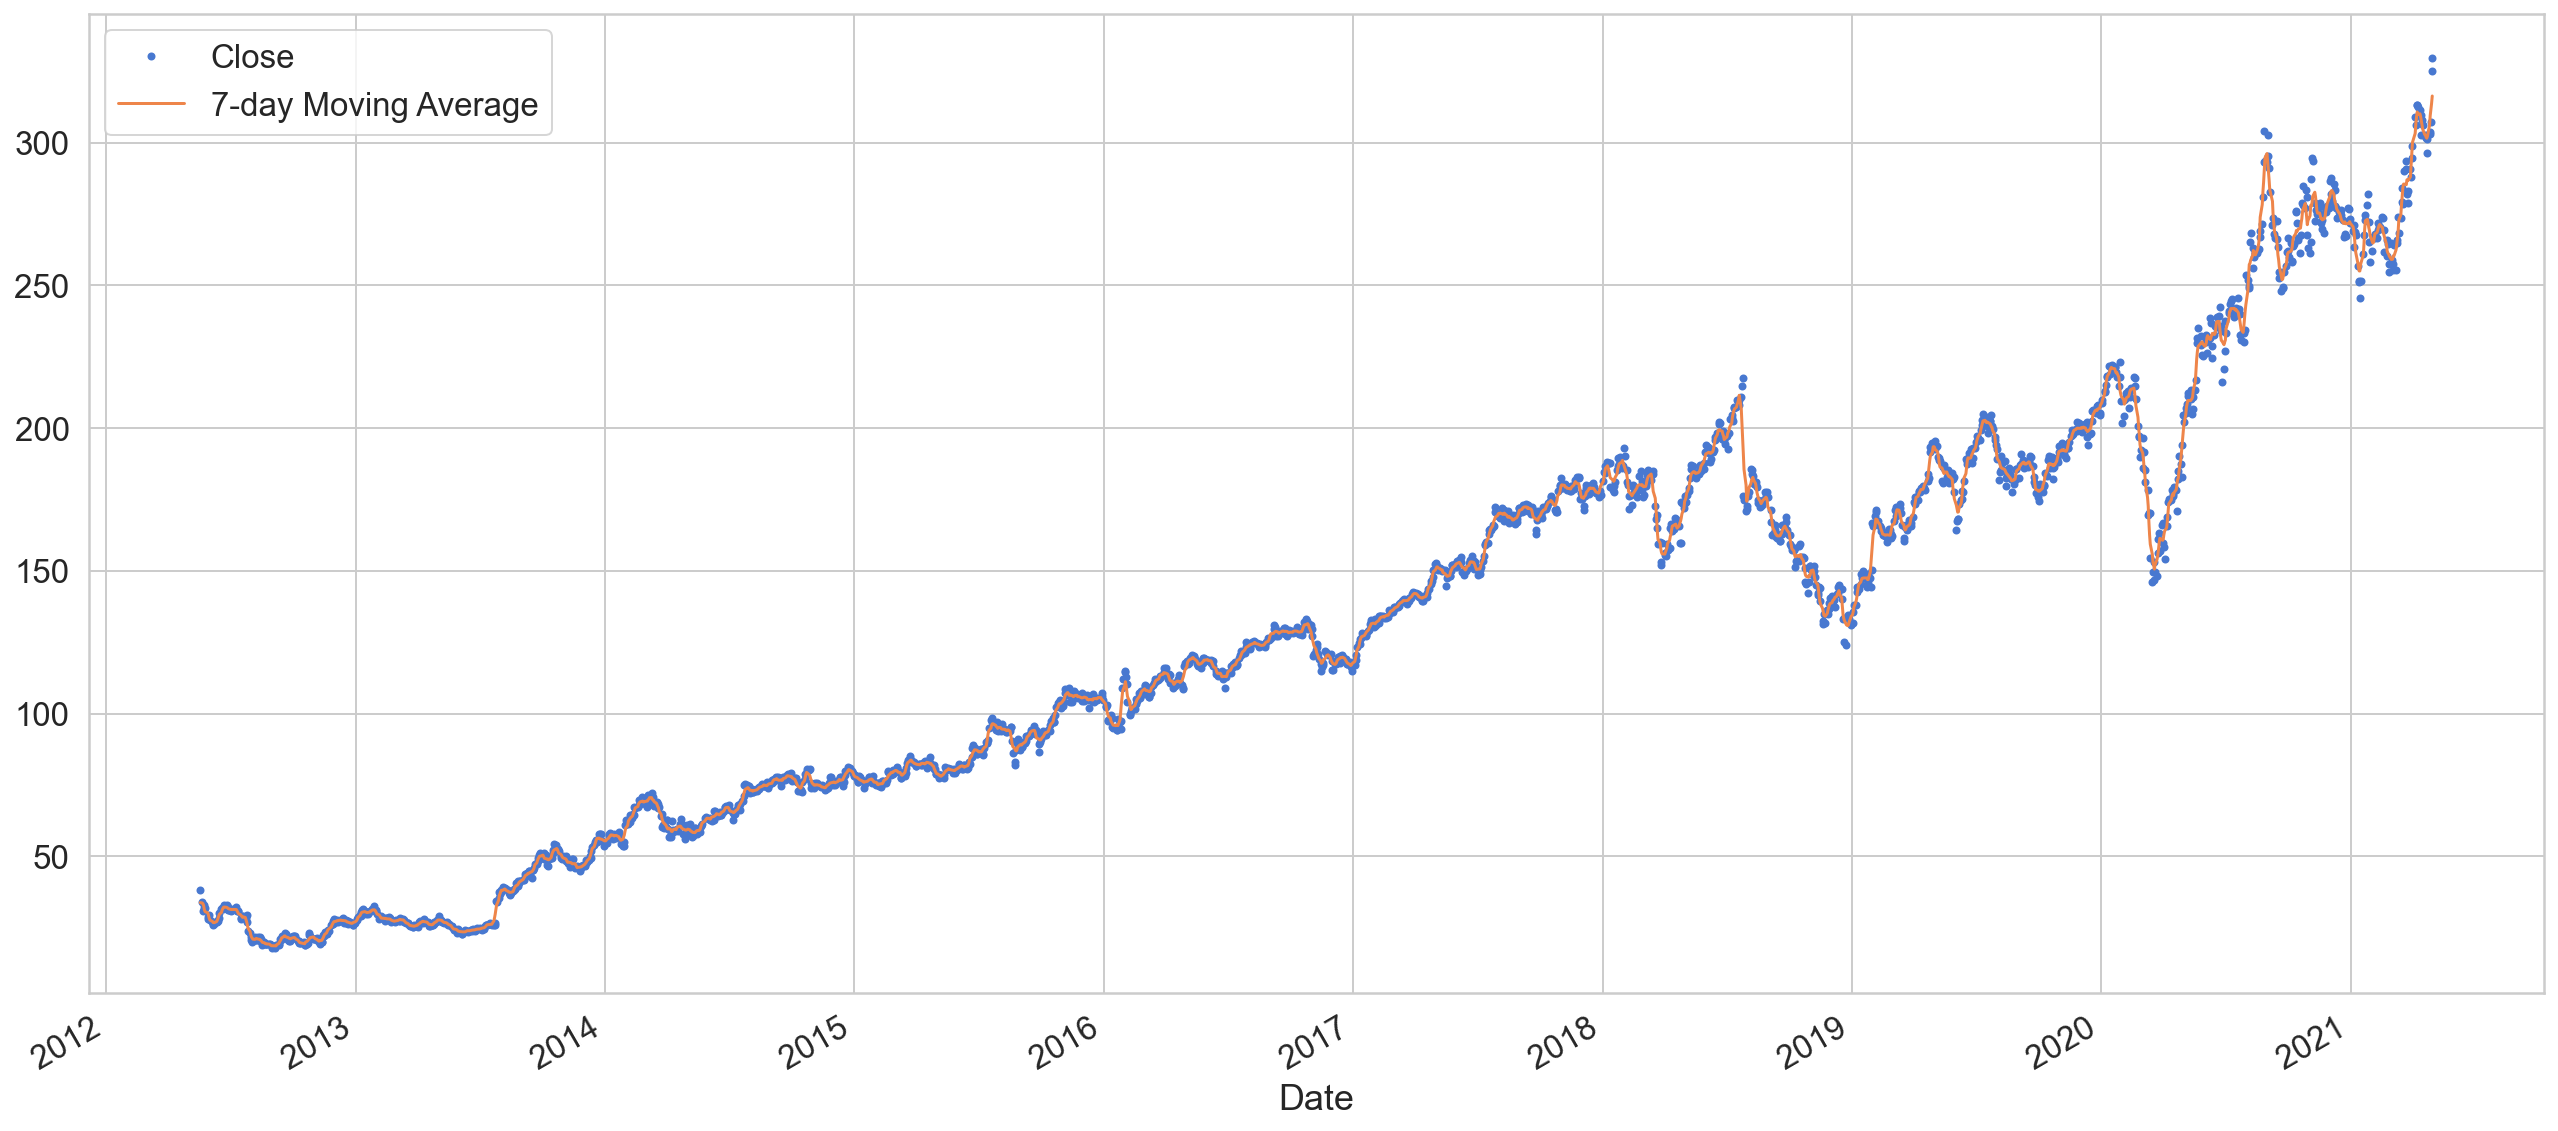

In [10]:
fig, ax = plt.subplots()
df['Close'].plot(marker='.', linestyle='', ax=ax)
df['Avg'].plot(ax=ax)
plt.legend(['Close', '7-day Moving Average'])
plt.show()

In [11]:
df.drop(columns=['Avg', 'dayOfWeek'], inplace=True)

In [12]:
df.head()

,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999


# Preprocessing

In [13]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df[['Close']].iloc[:train_size].copy(), df[['Close']].iloc[train_size:].copy()
print(len(train), len(test))

2026 226


In [14]:
from sklearn.preprocessing import RobustScaler, StandardScaler

target = 'Close'

# scaler = StandardScaler()
scaler = RobustScaler()

train.loc[:, target] = scaler.fit_transform(train[target].to_numpy().reshape(-1, 1))
test.loc[:, target] = scaler.transform(test[target].to_numpy().reshape(-1, 1))

In [15]:
# import pickle
# pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [16]:
# display(train.tail())
# display(test.head())

In [17]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        values = X.iloc[i:(i + time_steps)].values
        Xs.append(values)
        ys.append(y.iloc[i + time_steps])
    # ys = np.expand_dims(ys, 1)
    return np.array(Xs), np.array(ys)

In [18]:
time_steps = 10

# shape: [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train[target], time_steps)
X_test, y_test = create_dataset(test, test[target], time_steps)

print(X_train.shape, y_train.shape)

(2016, 10, 1) (2016,)


In [19]:
# X_test[0], y_test[0]

In [20]:
# X_test[1], y_test[1]

# Train

In [43]:
tf.random.set_seed(42)

In [44]:
# CONFIG
INIT_LR = 1e-3
EPOCHS = 50
BS = 32

In [45]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Bidirectional(LSTM(128, input_shape=[None, 1])),
    # Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)),
    Dropout(0.2),
    Dense(1)
])

In [46]:
# def last_time_step_mse(Y_true, Y_pred):
#     return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [47]:
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adam(lr=INIT_LR)

model.compile(loss='mse', optimizer=opt)

In [48]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("LSTM_checkpoint.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

In [49]:
history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BS, 
    validation_split=0.1,
    shuffle=False,
    # callbacks=[checkpoint_cb, early_stopping_cb]
    # callbacks=[checkpoint_cb]
)

Epoch 1/50
57/57 [==============================] - 3s 15ms/step - loss: 0.1118 - val_loss: 0.0133
Epoch 2/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0068
Epoch 3/50
57/57 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 4/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 5/50
57/57 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 6/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 7/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 8/50
57/57 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 9/50
57/57 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 10/50
57/57 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 11/50
57/57 

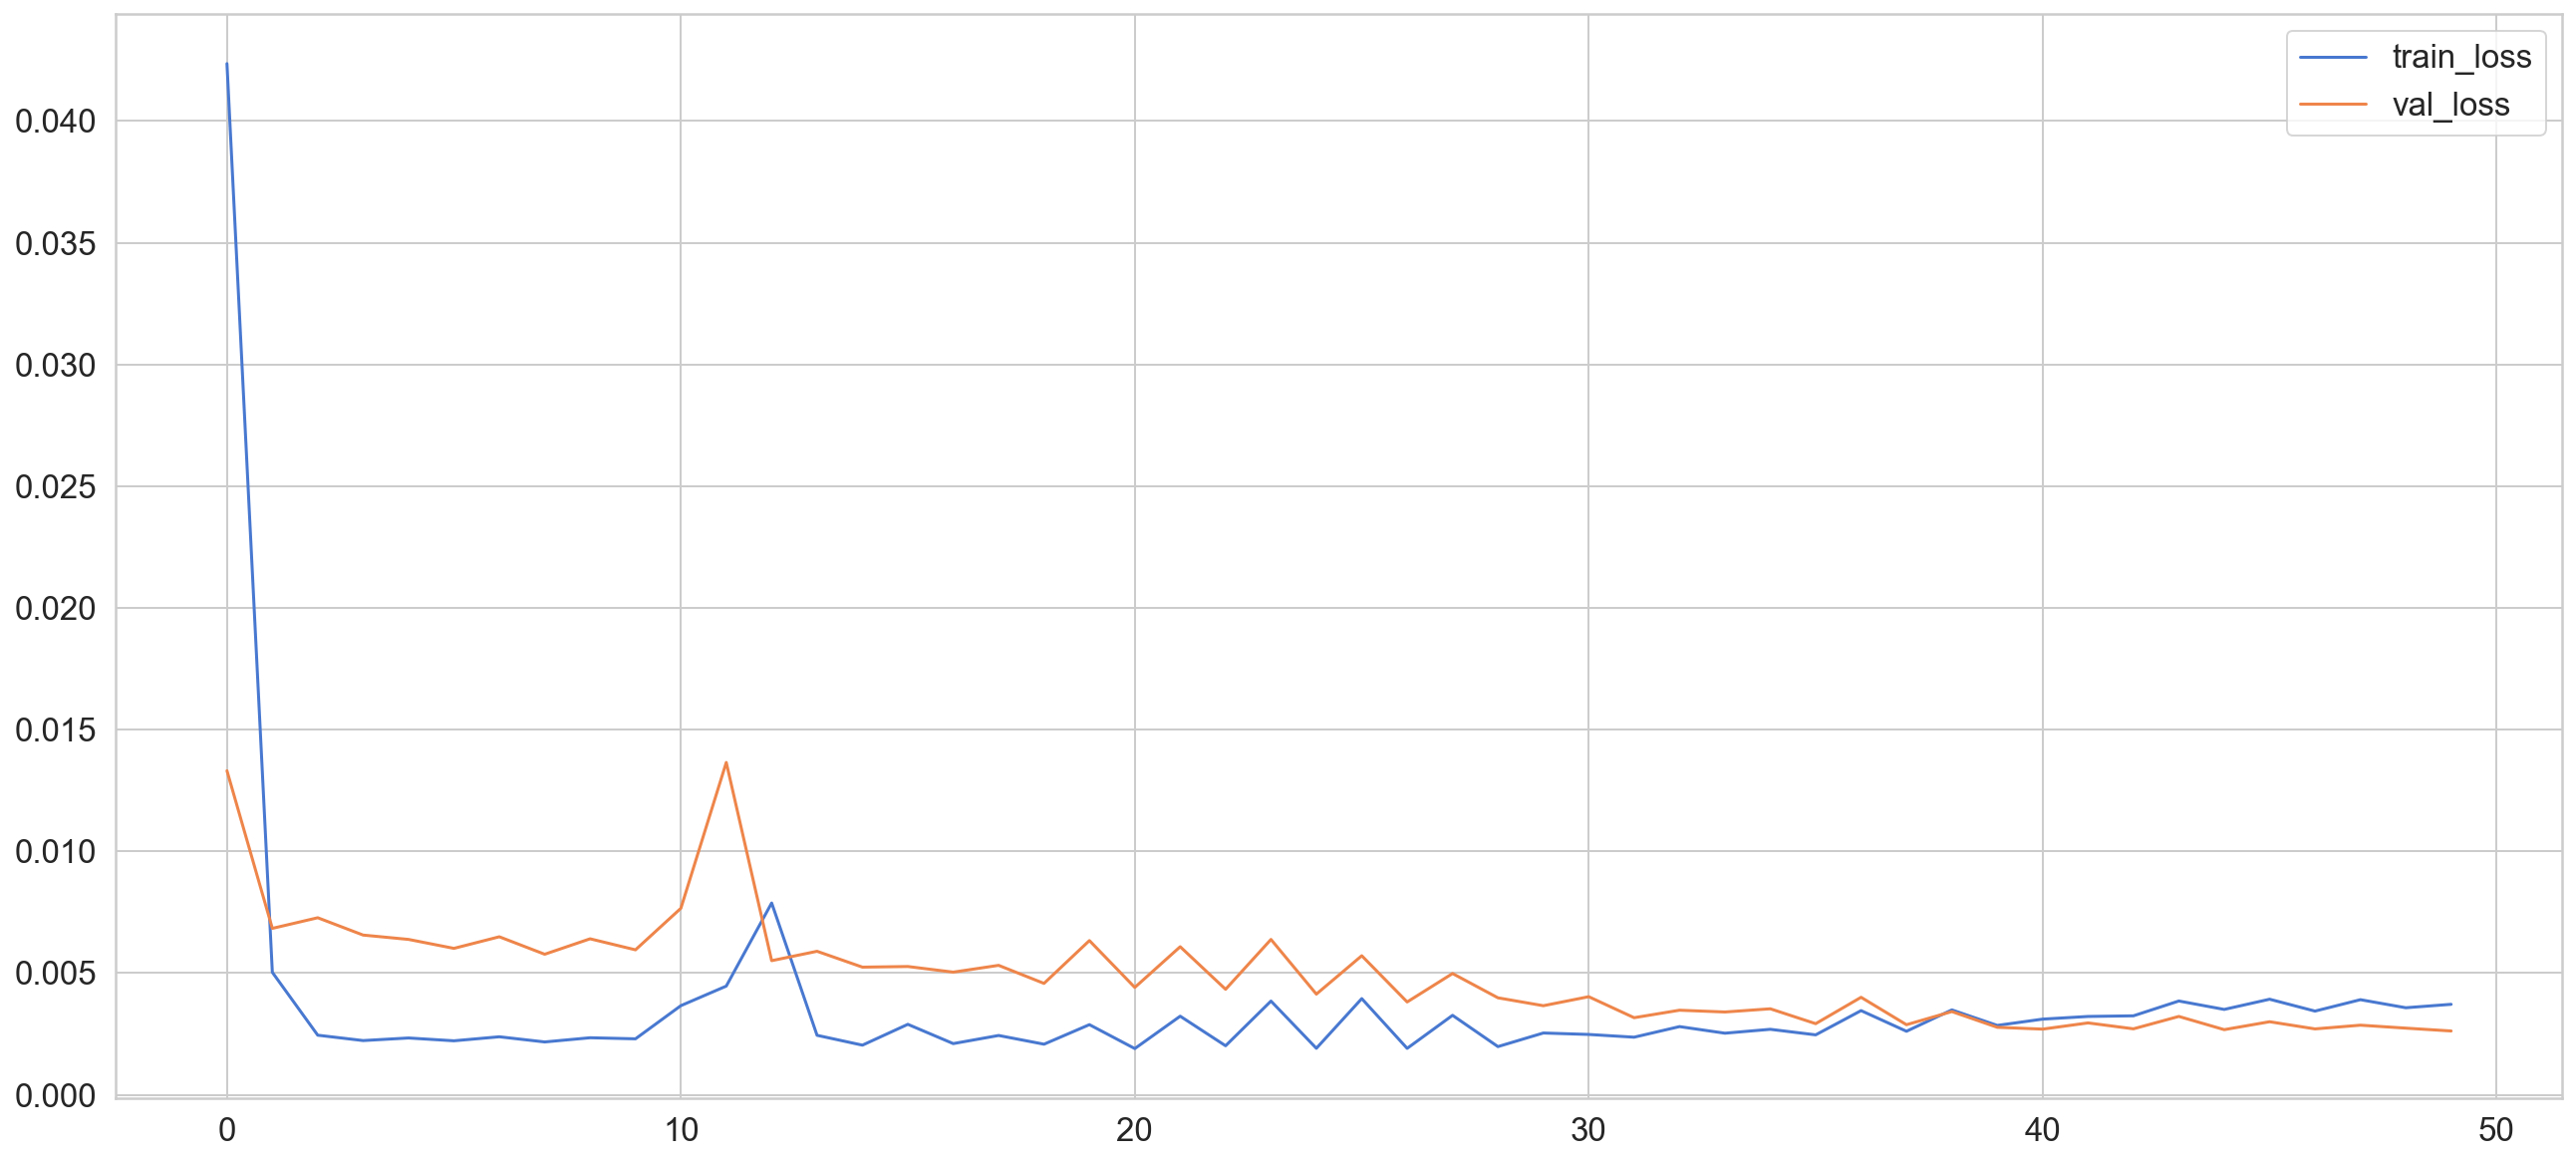

In [50]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend();

# Result

In [66]:
# model = keras.models.load_model('LSTM_checkpoint.h5')
model = keras.models.load_model('LSTM_model.h5')

In [67]:
y_pred = model.predict(X_test)

In [68]:
X_test.shape, y_test.shape, y_pred.shape

((216, 10, 1), (216,), (216, 1))

In [69]:
y_test[:5]

array([1.21014214, 1.13119477, 1.1471378 , 0.95889356, 1.00268916])

In [70]:
y_pred[:5]

array([[1.1808338],
       [1.1747836],
       [1.1283743],
       [1.1132479],
       [1.0110133]], dtype=float32)

In [75]:
import pickle
scaler = pickle.load(open('scaler.pkl', 'rb'))

In [76]:
y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = scaler.inverse_transform(y_pred)
# y_pred_inv = scaler.inverse_transform(y_pred.mean(axis=1))

In [77]:
y_train[:5]

array([-0.85804833, -0.86794075, -0.85891272, -0.86371487, -0.85612747])

In [78]:
y_train_inv[0, :5], y_test_inv[0, :5], y_pred_inv[0, :5]

(array([26.89999962, 25.87000084, 26.80999947, 26.30999947, 27.10000038]),
 array([242.24000549, 234.02000427, 235.67999268, 216.08000183,
        220.63999939]),
 array([239.18842], dtype=float32))

In [79]:
y_train_inv = y_train_inv.flatten()
y_test_inv = y_test_inv.flatten()
y_pred_inv = y_pred_inv.flatten()

In [80]:
# y_train_df = pd.DataFrame(y_train_inv, index=train.iloc[time_steps:].index)
y_test_df = pd.DataFrame(y_test_inv, index=test.iloc[time_steps:].index)
y_pred_df = pd.DataFrame(y_pred_inv, index=test.iloc[time_steps:].index)
# y_test_df.tail()

In [81]:
# df['train'] = y_train_df
df['test'] = y_test_df
df['pred'] = y_pred_df
# df[['pred']].dropna()

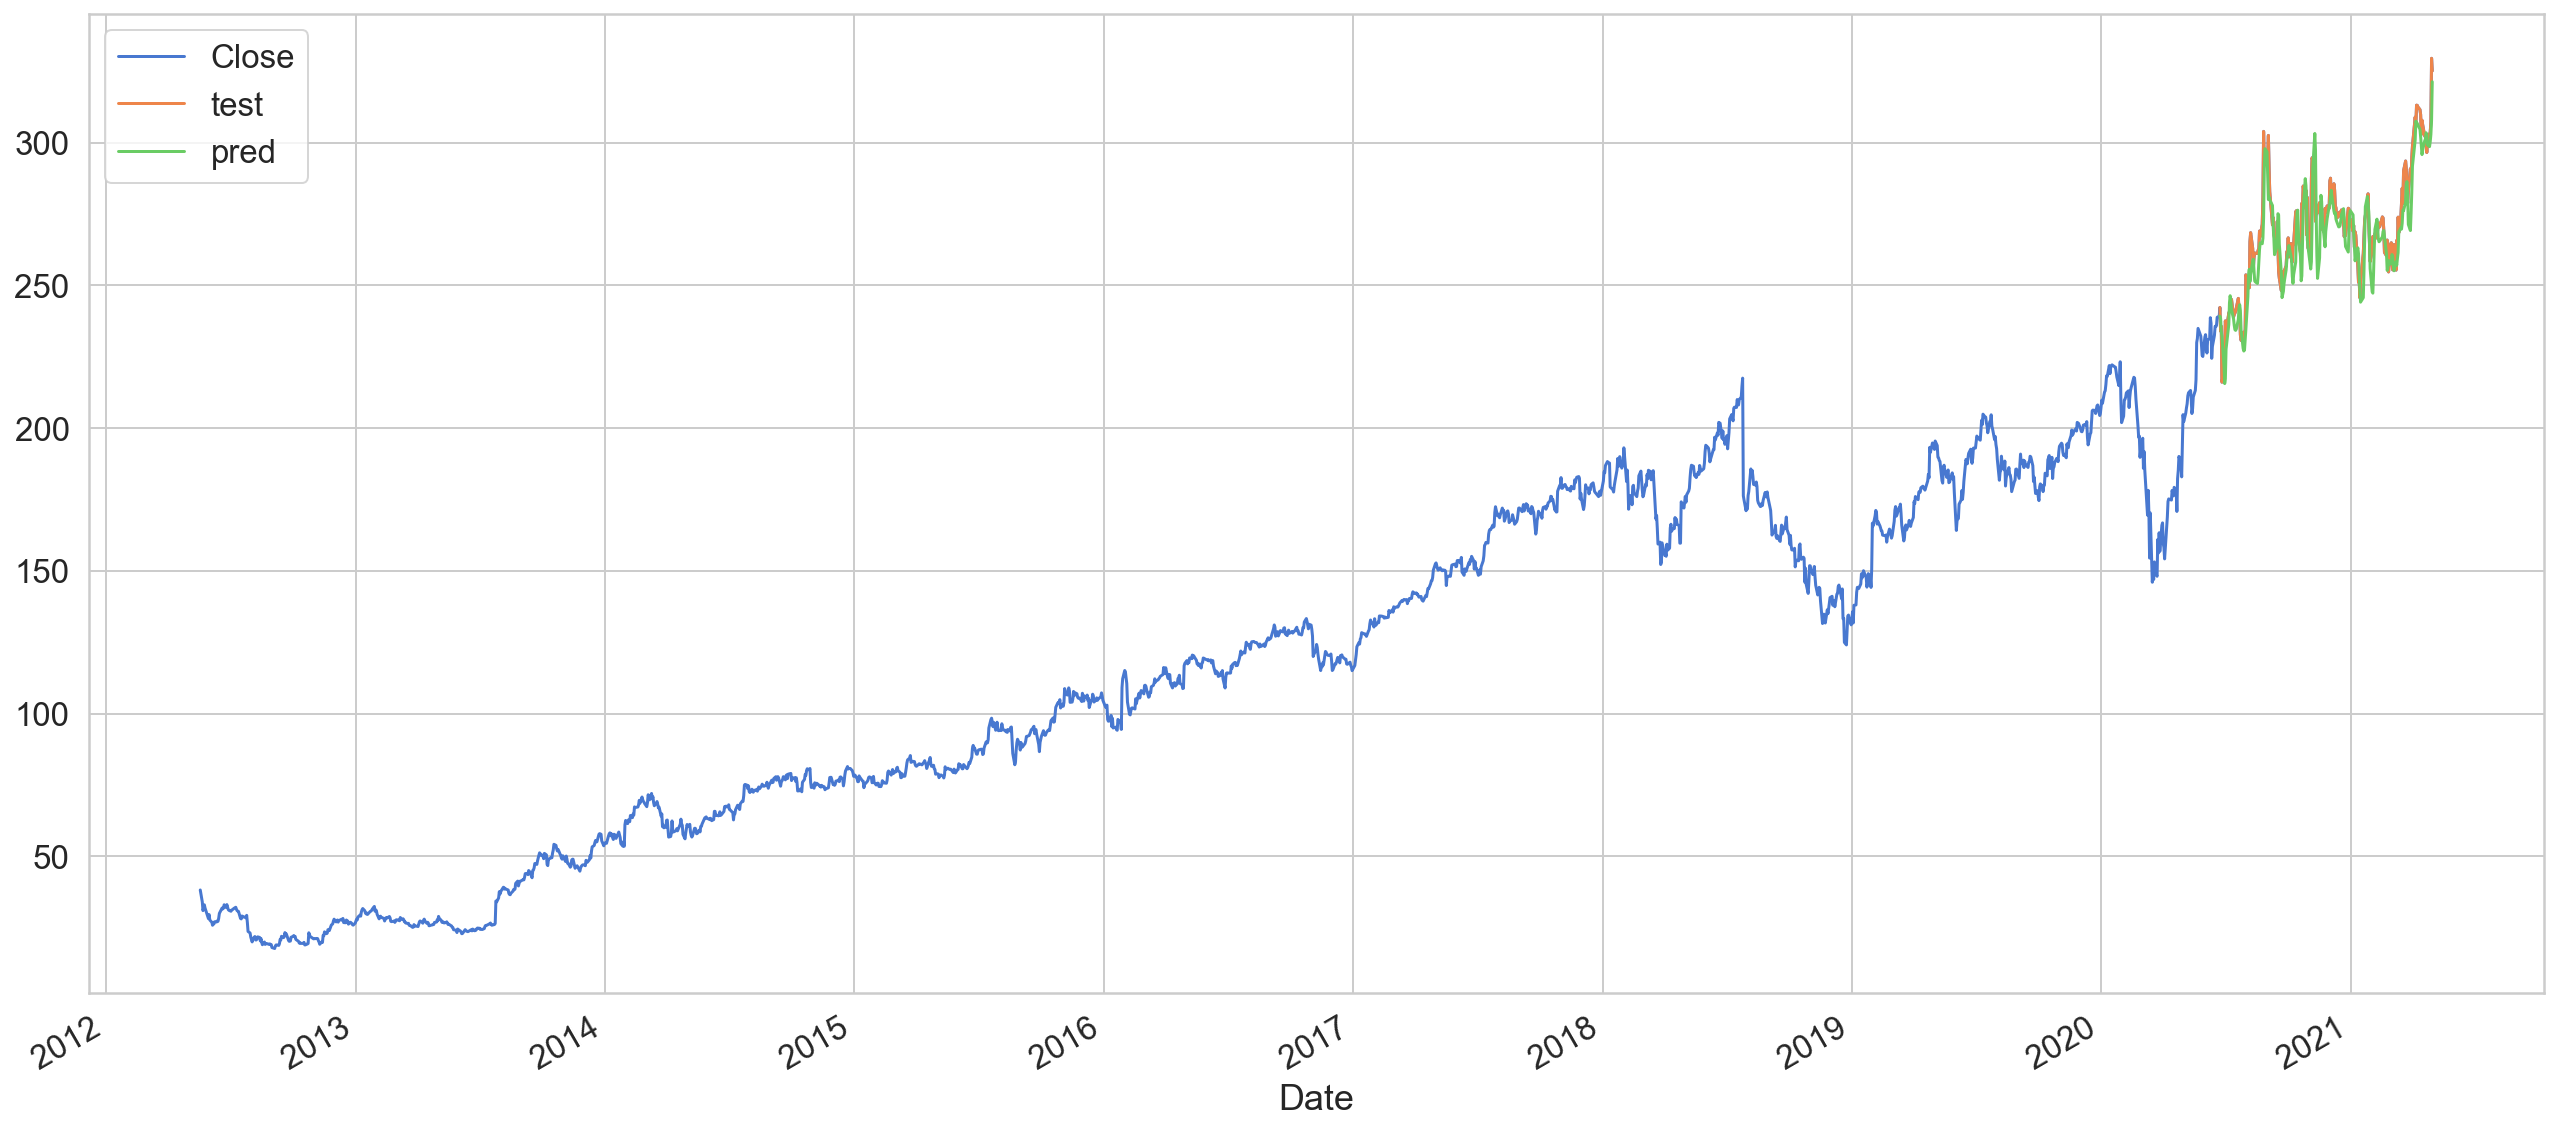

In [82]:
df[['Close', 'test', 'pred']].plot()
plt.show()

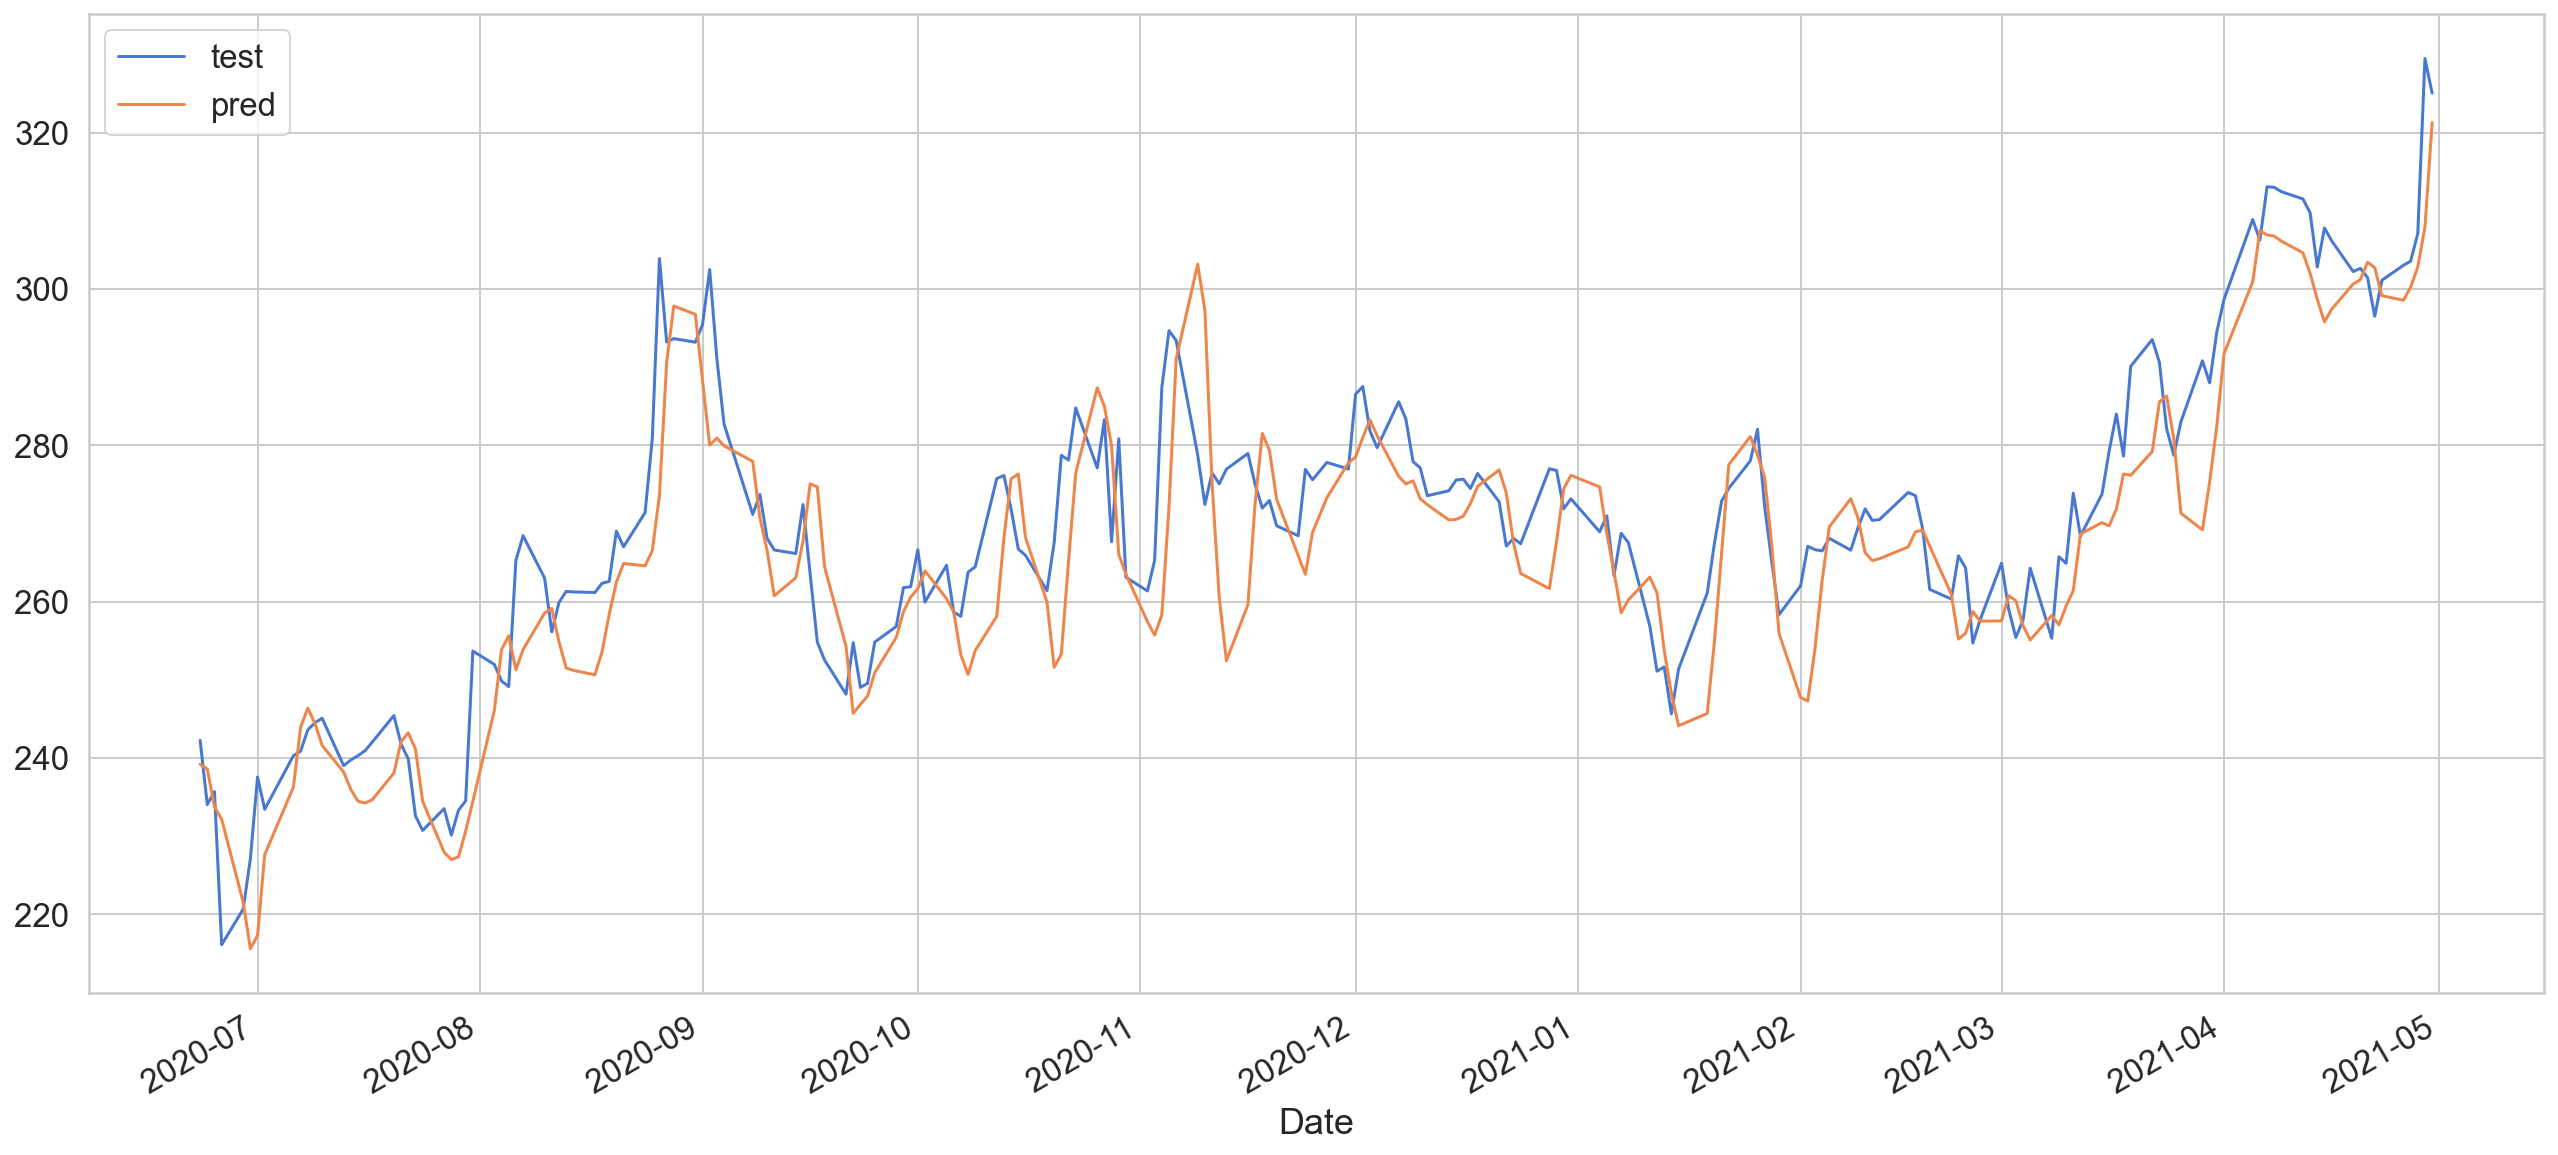

In [83]:
df[['test', 'pred']].plot()
plt.show()

In [84]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(df.dropna()['test'], df.dropna()['pred'], squared=False)
# 9.2134
print(f"RMSE = {RMSE}")

RMSE = 9.213408681808748


# Future Forecast on Test Dates (w/o cheating)

In [85]:
scaled_df = scaler.transform(df['Close'].values.reshape(-1, 1))
scaled_df = pd.DataFrame(scaled_df, index=df.index, columns=['Close'])
scaled_df.head()

,Close
Date,
2012-05-18,-0.749232
2012-05-21,-0.789570
2012-05-22,-0.818671
2012-05-23,-0.809066
2012-05-24,-0.799174


In [86]:
first_test = X_test[0].reshape(1, 10, 1)
first_test.shape

(1, 10, 1)

In [87]:
first_test_date = df.dropna().iloc[0].name
first_test_date

Timestamp('2020-06-23 00:00:00')

In [88]:
X_test.shape

(216, 10, 1)

In [89]:
prev_data = first_test
current_date = first_test_date
current_index = df.index.get_loc(current_date)
current_index += 1
current_index

2037

In [90]:
X_test.shape

(216, 10, 1)

In [91]:
def forecast_test():
    prev_data = first_test
    current_date = first_test_date
    current_index = scaled_df.index.get_loc(current_date)
    for i in range(len(X_test)):
        if i <= 10:
            try:
                pred = model.predict(prev_data)
                current_index += 1
                prev_data = scaled_df.iloc[current_index - 10: current_index, 0].values
                # print(prev_data)
                # break
                prev_data = prev_data.reshape(1, 10, 1)
            except Exception as e:
                print(f"[ERROR] {e.__class__.__name__} on index {i}")
                raise Exception

            if i == 0:
                real_preds = pred
            else:
                real_preds = np.append(real_preds, pred)
        else:
            try:
                prev_data = real_preds[-10:].reshape(1, 10, 1)
                pred = model.predict(prev_data)
                real_preds = np.append(real_preds, pred)
            except Exception as e:
                print(f"[ERROR] {e.__class__.__name__} on index {i}")
                raise Exception
    return real_preds

In [92]:
real_preds = forecast_test()

In [93]:
y_test.shape

(216,)

In [94]:
real_preds.shape

(216,)

In [95]:
real_preds_inv = scaler.inverse_transform(real_preds.reshape(-1, 1))
real_preds_df = pd.DataFrame(real_preds_inv, index=test.iloc[time_steps:].index)
df['real_preds'] = real_preds_df
df.tail()

,Close,test,pred,real_preds
Date,,,,
2021-04-26,303.040009,303.040009,298.574341,198.657272
2021-04-27,303.570007,303.570007,300.226410,198.631073
2021-04-28,307.100006,307.100006,302.847778,198.605194
2021-04-29,329.510010,329.510010,307.917969,198.579620
2021-04-30,325.079987,325.079987,321.319031,198.554352


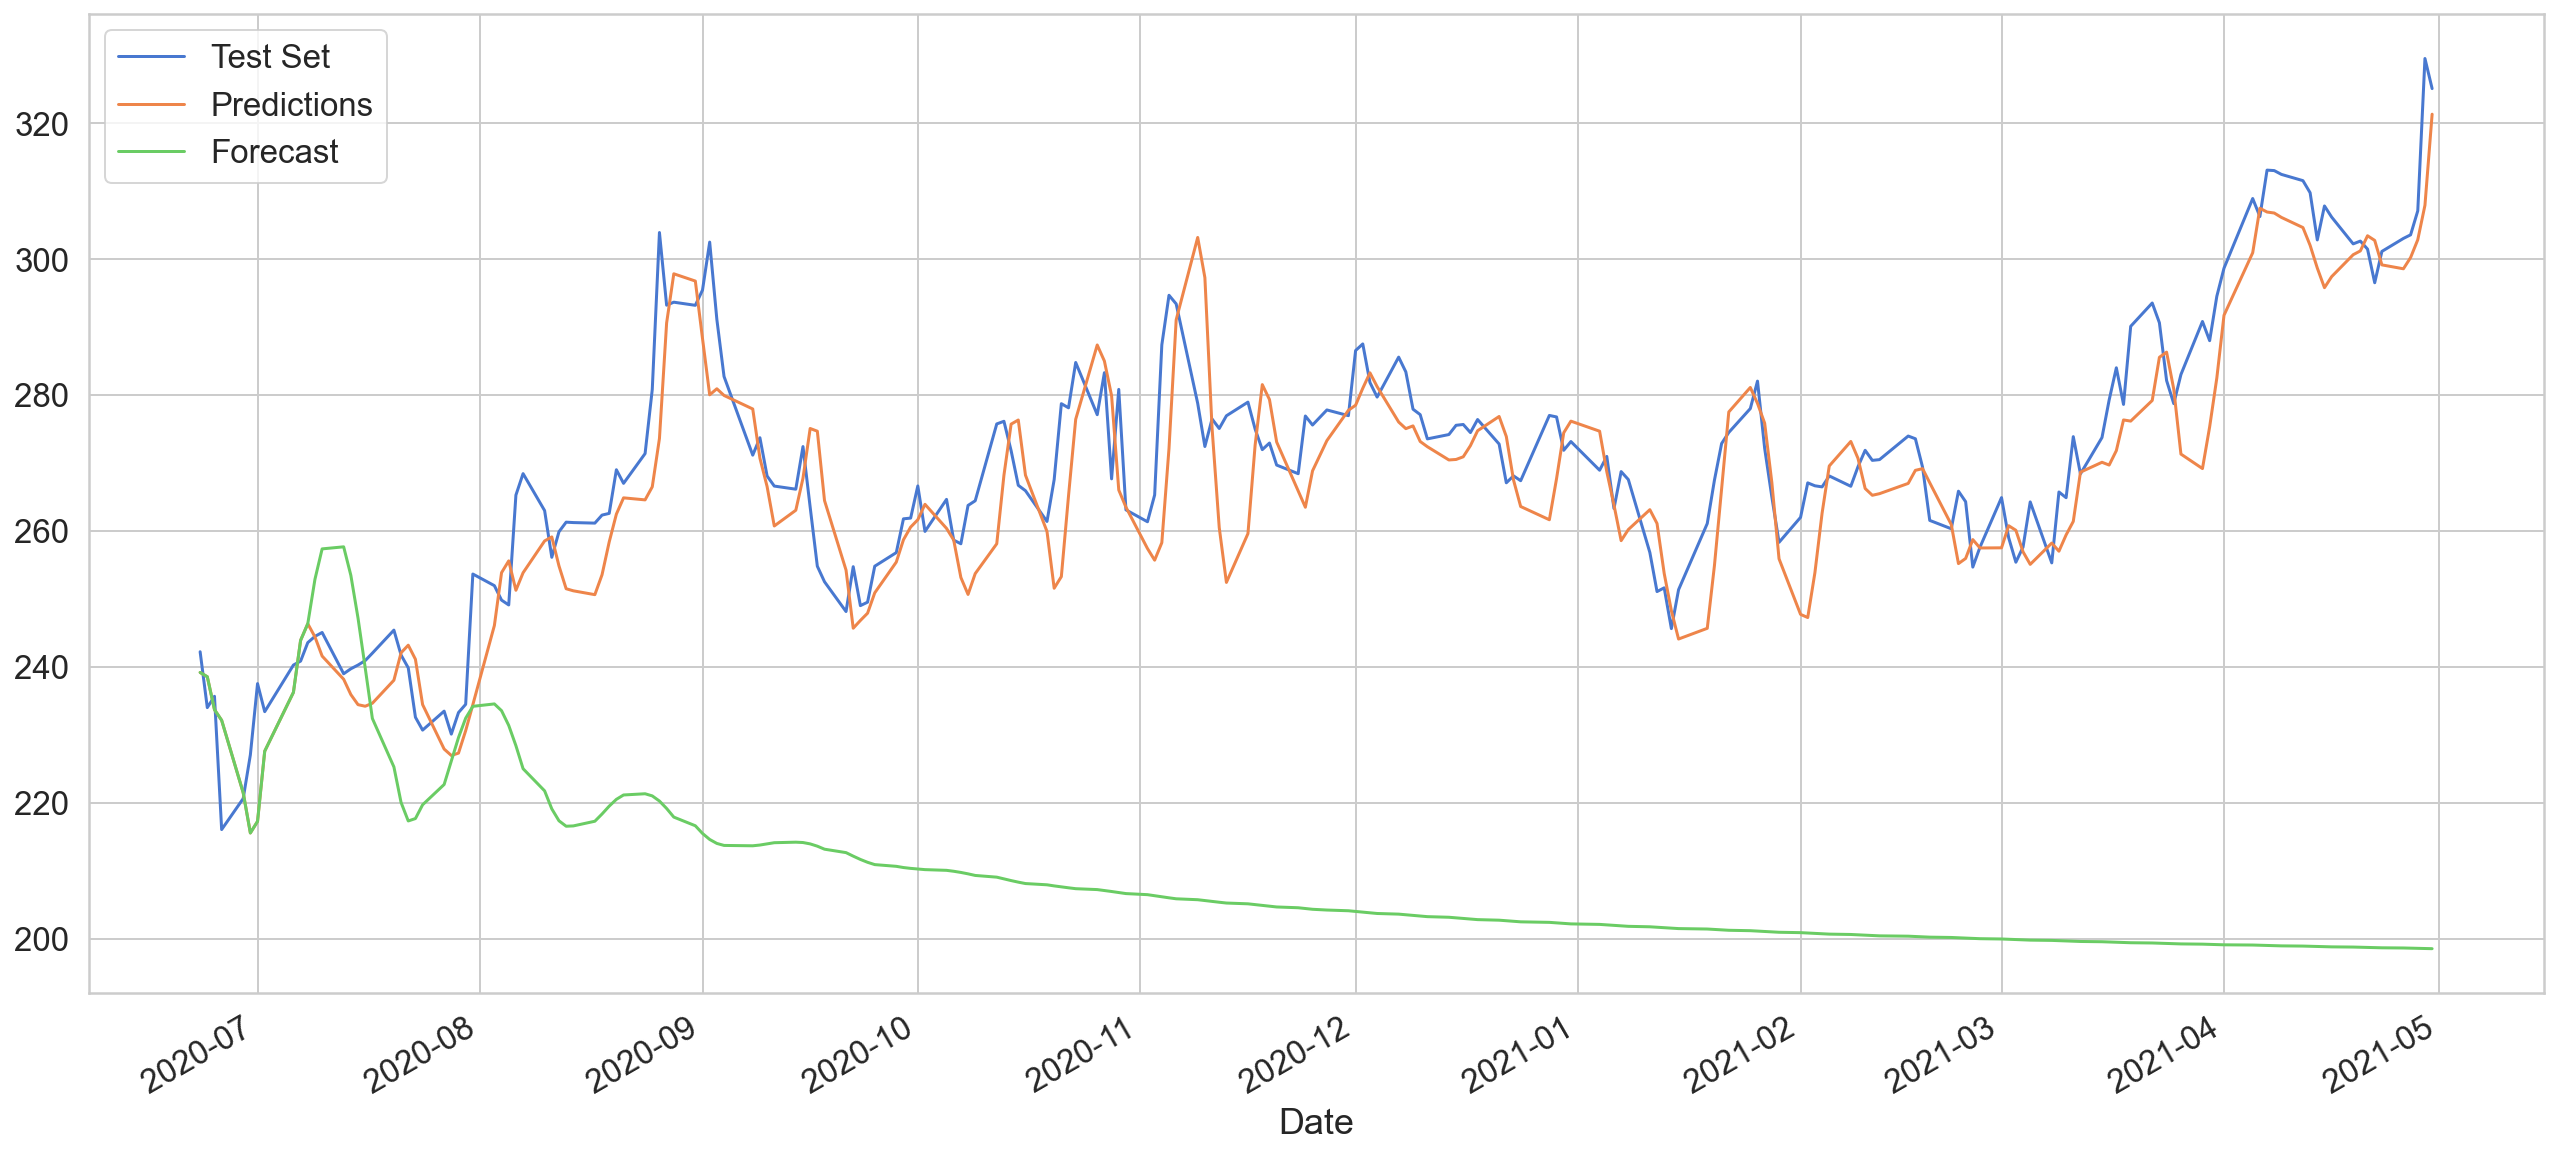

In [96]:
df[['test', 'pred', 'real_preds']].plot()
plt.legend(labels=['Test Set', 'Predictions', 'Forecast'])
plt.show()

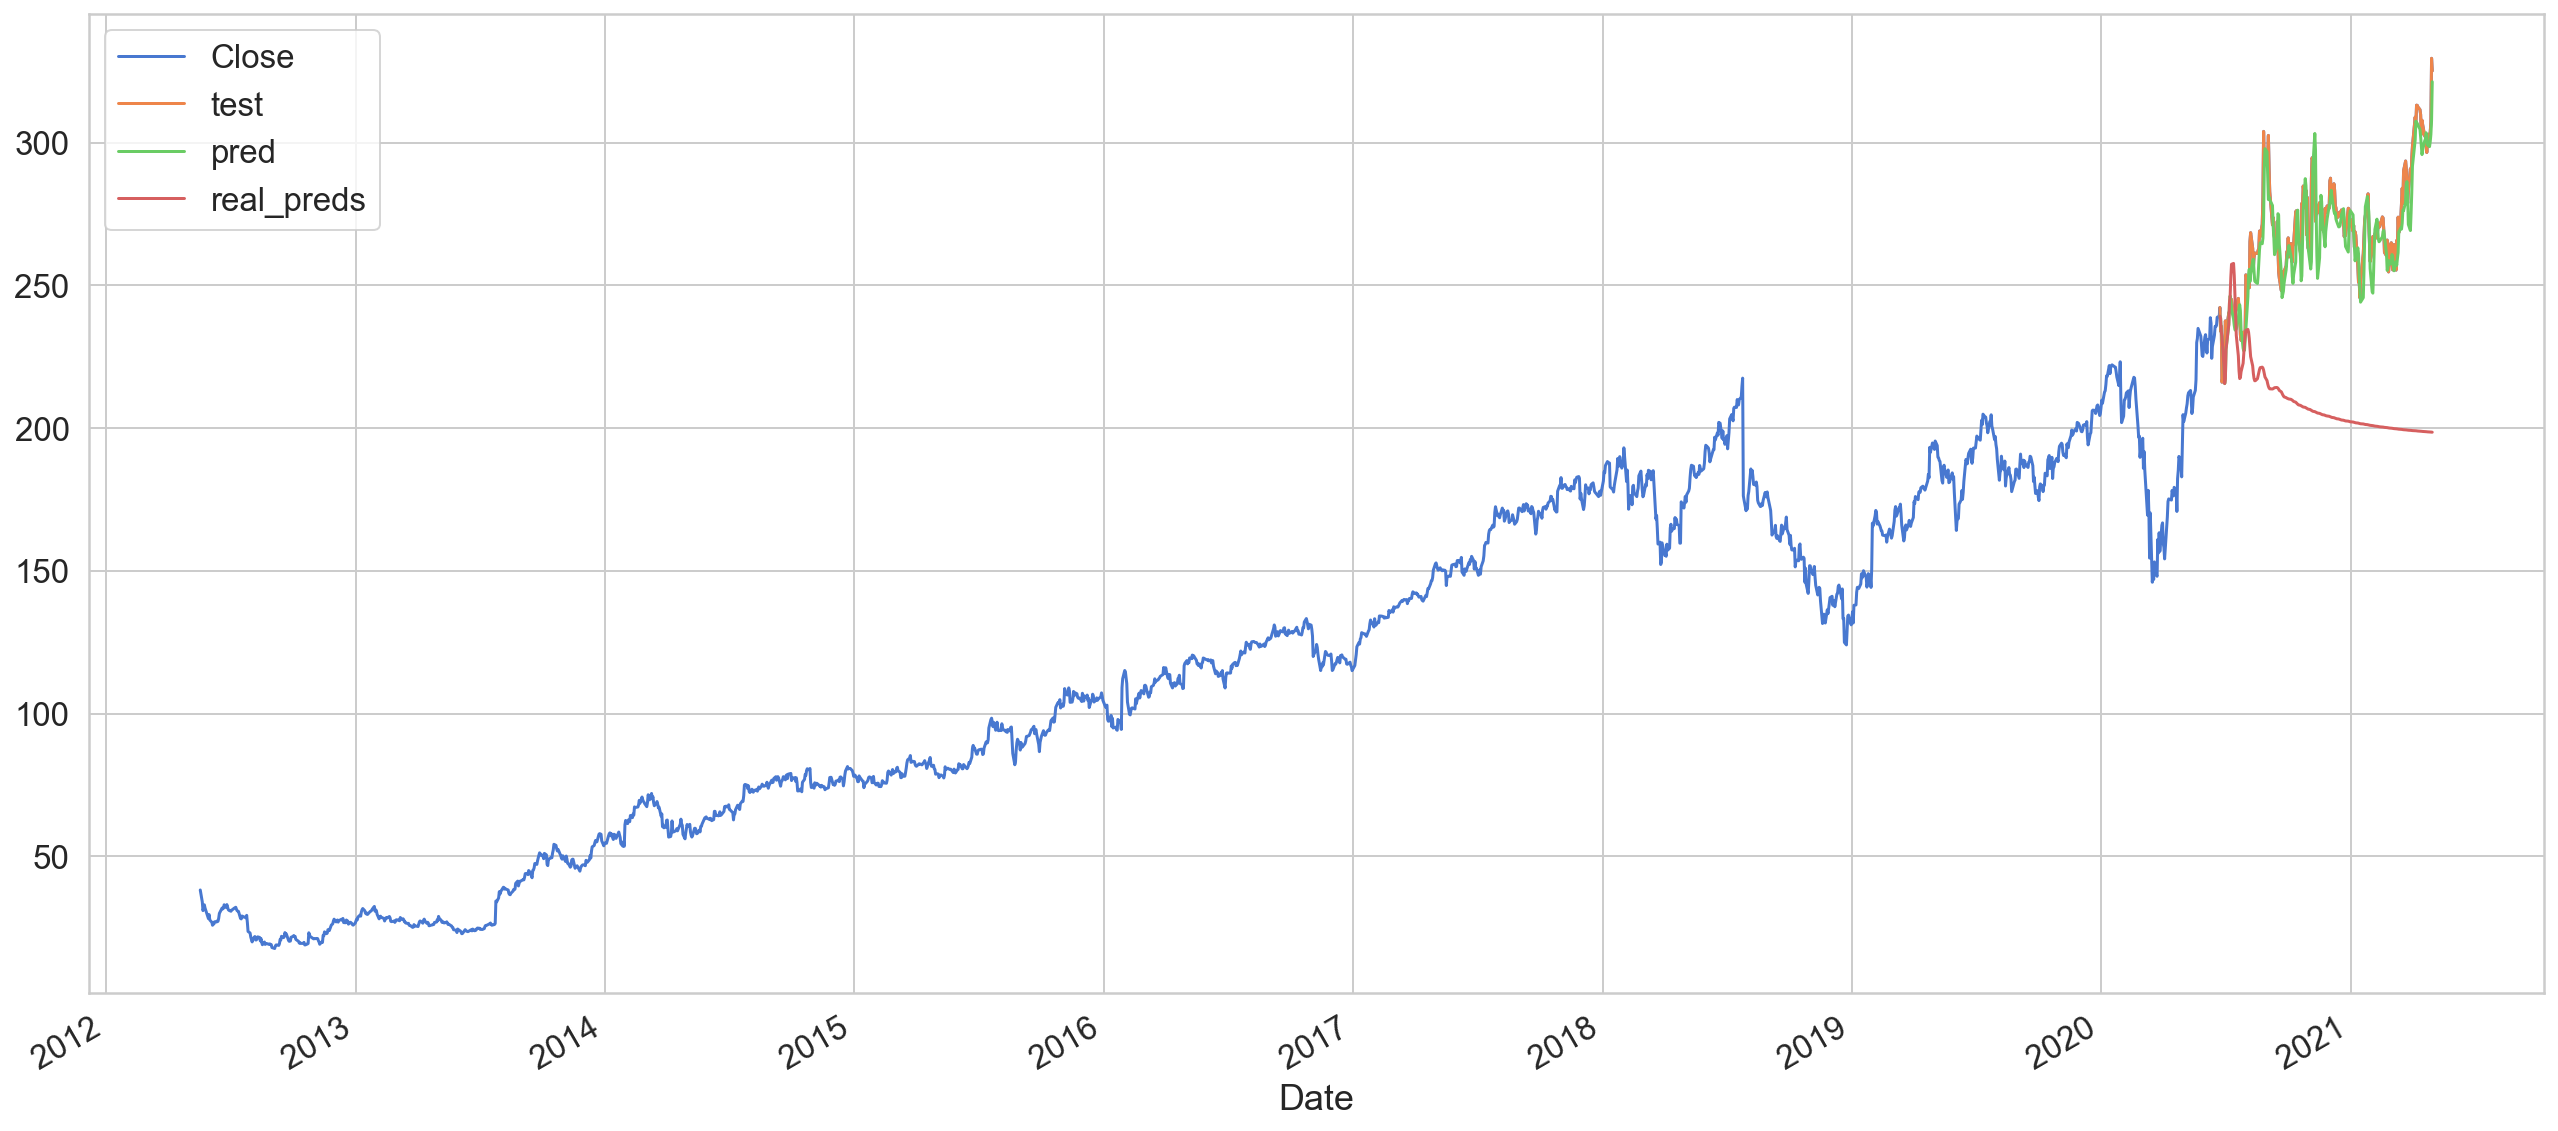

In [97]:
df.plot()
plt.show()

# Future Forecast

In [98]:
# model = keras.models.load_model('LSTM_model.h5')

In [99]:
# import pickle
# scaler = pickle.load(open('scaler.pkl', 'rb'))

In [100]:
final_test = scaler.transform(df.iloc[-10:, 0].to_numpy().reshape(-1, 1))
final_test = final_test.flatten()
final_test

array([1.78640012, 1.79033792, 1.77900491, 1.7314635 , 1.77573949,
       1.79408374, 1.79917401, 1.83307718, 2.04830963, 2.00576235])

In [101]:
final_date = df.iloc[-1].name
final_date

Timestamp('2021-04-30 00:00:00')

In [102]:
forecast_days = 10
date_after_final = final_date + timedelta(days=1)
future_dates = pd.date_range(start=date_after_final, periods=forecast_days, freq='B')
future_dates

DatetimeIndex(['2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
               '2021-05-07', '2021-05-10', '2021-05-11', '2021-05-12',
               '2021-05-13', '2021-05-14'],
              dtype='datetime64[ns]', freq='B')

In [103]:
prev_data = final_test.reshape(1, 10, 1)
current_date = final_date
current_index = - time_steps

for i in range(forecast_days):
    if i < 10:
        try:
            pred = model.predict(prev_data)
            if i == 0:
                future_pred = pred
            else:
                future_pred = np.append(future_pred, pred)
            current_index += 1
            # take certain rows from the original data, care the shape
            test_data = final_test[current_index:]
            if current_index == 0:
                # to prevent appending the entire dataset
                test_data = []
            prev_data = np.append(test_data, future_pred).reshape(1, 10, 1)
        except Exception as e:
            print(f"[ERROR] {e.__class__.__name__} on index {i}")
            raise Exception
    else:
        try:
            prev_data = future_pred[-10:].reshape(1, 10, 1)
            pred = model.predict(prev_data)
            future_pred = np.append(future_pred, pred)
        except Exception as e:
            print(f"[ERROR] {e.__class__.__name__} on index {i}")
            raise Exception

In [104]:
future_pred_inv = scaler.inverse_transform(future_pred.reshape(-1, 1))
future_pred_df = pd.DataFrame(future_pred_inv, index=future_dates, columns=['future'])
future_pred_df.head(10)

,future
2021-05-03,329.404236
2021-05-04,333.977692
2021-05-05,333.071320
2021-05-06,326.611908
2021-05-07,317.869232
2021-05-10,306.872894
2021-05-11,296.255829
2021-05-12,288.649902
2021-05-13,285.268982
2021-05-14,282.446838


In [105]:
future_pred_df.shape

(10, 1)

In [106]:
x = final_test.reshape(1, 10, 1)
scaler.inverse_transform(model.predict(x).reshape(-1, 1))

array([[329.40424]], dtype=float32)

In [107]:
x = np.append(final_test[-9:], model.predict(x)).reshape(1, 10, 1)
scaler.inverse_transform(model.predict(x).reshape(-1, 1))

array([[333.9777]], dtype=float32)

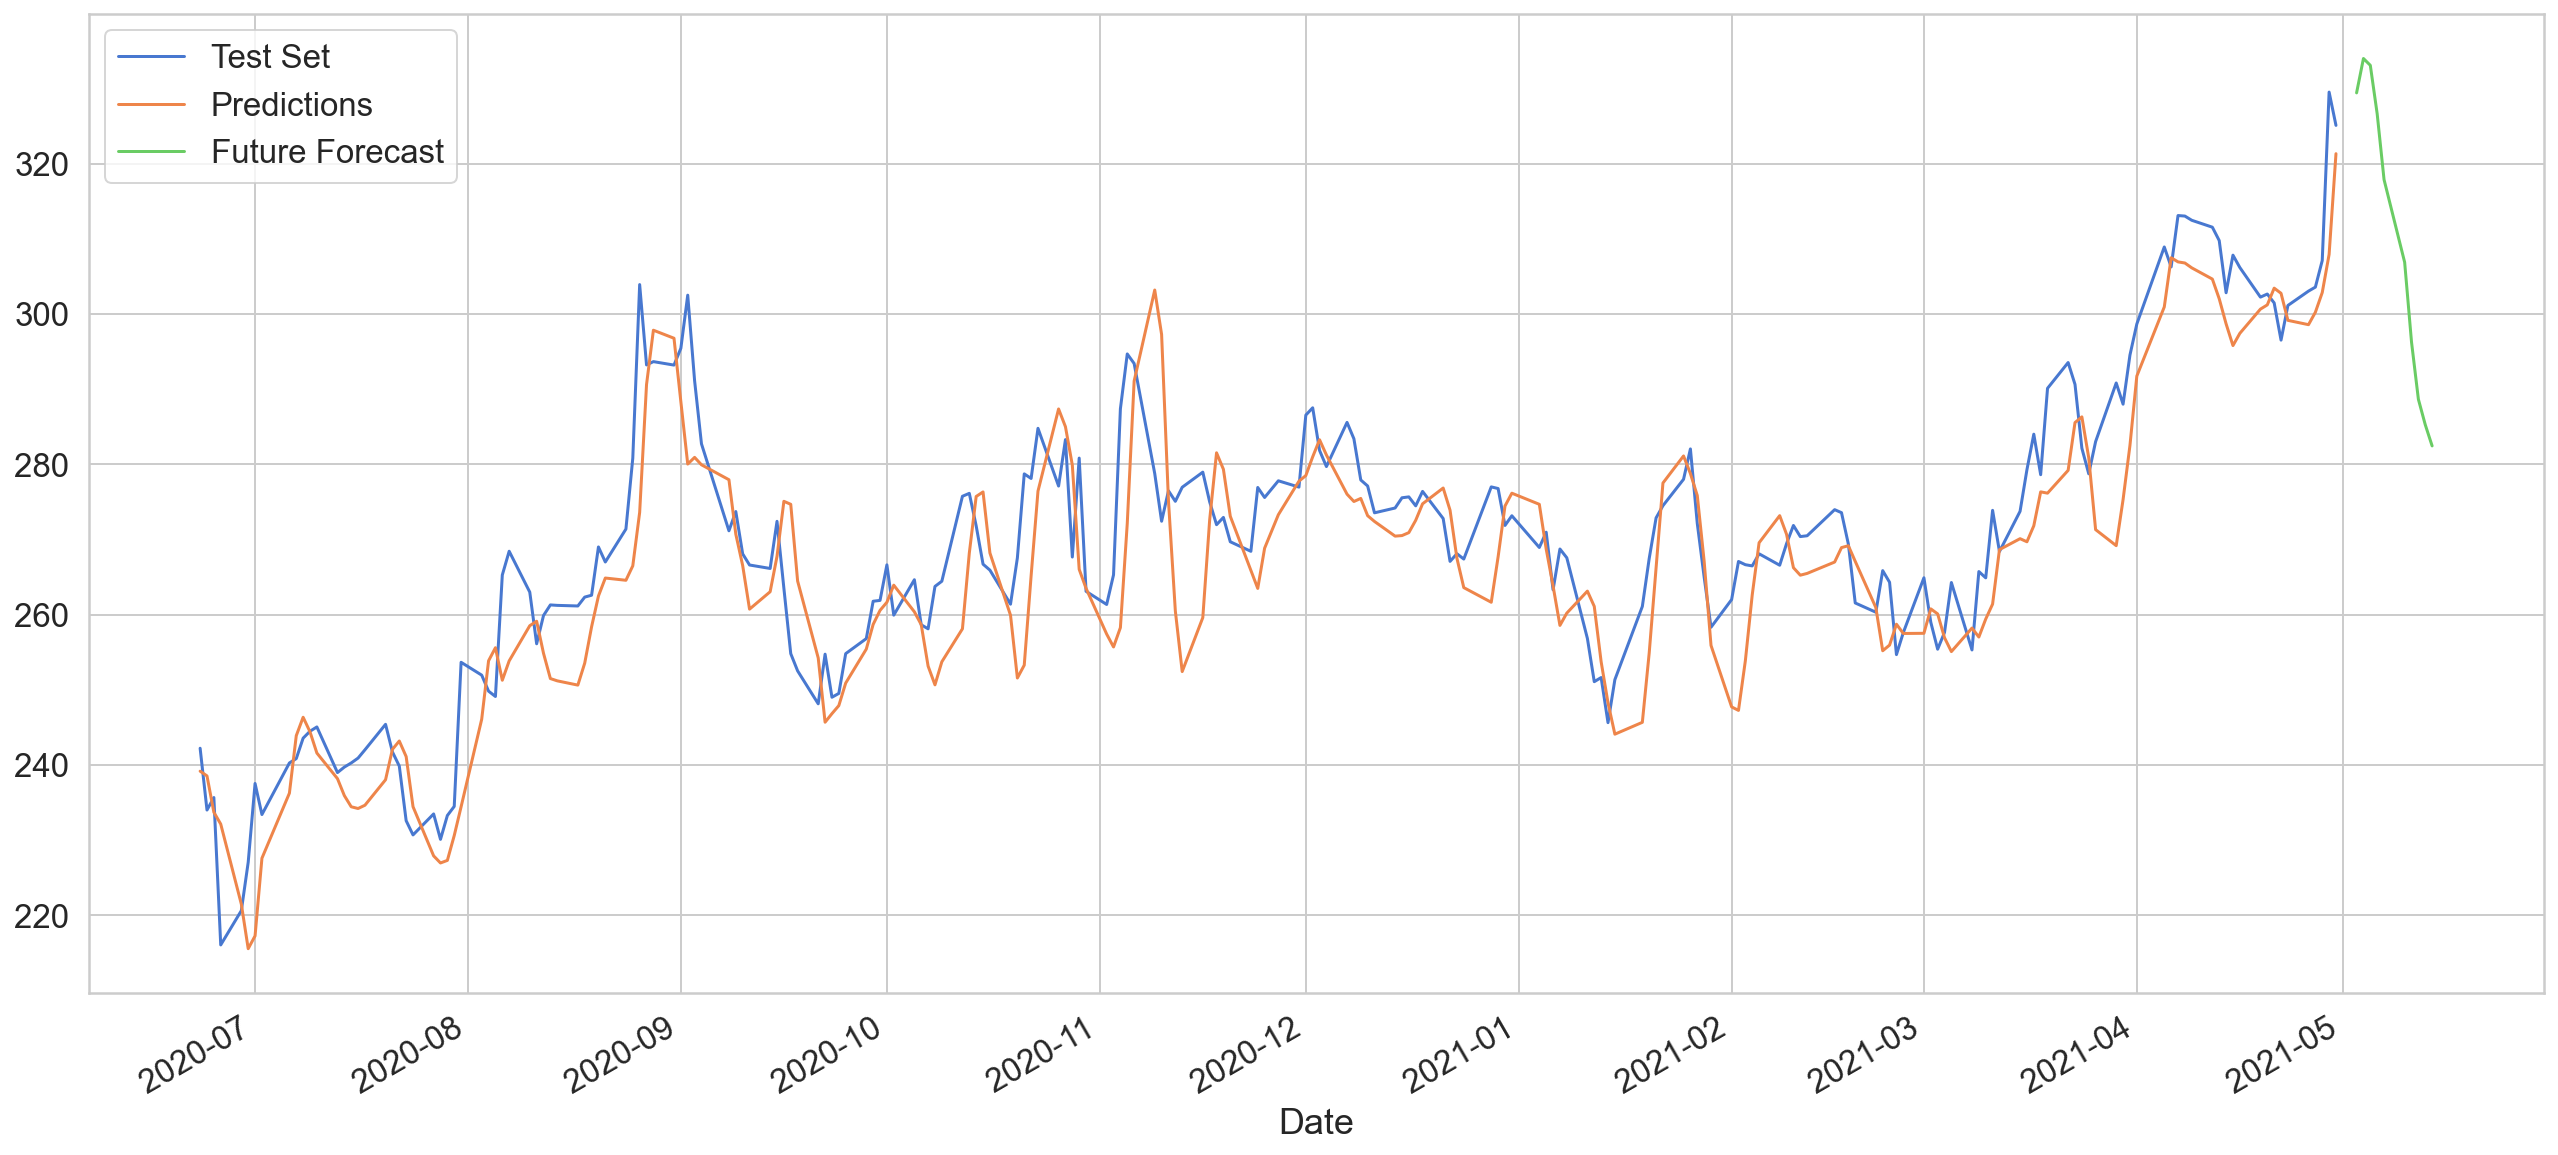

In [108]:
fig, ax = plt.subplots()
df[['test', 'pred']].plot(ax=ax, legend=True)
future_pred_df.plot(ax=ax, legend=True)
plt.legend(['Test Set', 'Predictions', 'Future Forecast'])
plt.show()

In [109]:
df.dropna().tail()

,Close,test,pred,real_preds
Date,,,,
2021-04-26,303.040009,303.040009,298.574341,198.657272
2021-04-27,303.570007,303.570007,300.226410,198.631073
2021-04-28,307.100006,307.100006,302.847778,198.605194
2021-04-29,329.510010,329.510010,307.917969,198.579620
2021-04-30,325.079987,325.079987,321.319031,198.554352


# Save forecast

In [110]:
# model.save('LSTM_model.h5')

In [111]:
results_df = pd.read_csv('results_withProphet.csv', index_col=[0], parse_dates=[0])
results_df.head()

,Close,ARIMA,SARIMAX,Prophet
2012-05-18,38.230000,NaN,NaN,20.585618
2012-05-21,34.029999,NaN,NaN,20.495611
2012-05-22,31.000000,NaN,NaN,20.816885
2012-05-23,32.000000,NaN,NaN,20.963297
2012-05-24,33.029999,NaN,NaN,21.005824


In [112]:
future_pred_df.tail()

,future
2021-05-10,306.872894
2021-05-11,296.255829
2021-05-12,288.649902
2021-05-13,285.268982
2021-05-14,282.446838


In [113]:
results_df['LSTM_pred'] = df['pred']
display(results_df[['LSTM_pred']].dropna().head())
display(results_df[['LSTM_pred']].dropna().tail())

,LSTM_pred
2020-06-23,239.188416
2020-06-24,238.558472
2020-06-25,233.726349
2020-06-26,232.151367
2020-06-29,221.506714


,LSTM_pred
2021-04-26,298.574341
2021-04-27,300.226410
2021-04-28,302.847778
2021-04-29,307.917969
2021-04-30,321.319031


In [114]:
results_df['LSTM_future'] = future_pred_df
display(results_df[['LSTM_future']].dropna().head())
display(results_df[['LSTM_future']].dropna().tail())

,LSTM_future
2021-05-03,329.404236
2021-05-04,333.977692
2021-05-05,333.071320
2021-05-06,326.611908
2021-05-07,317.869232


,LSTM_future
2021-05-10,306.872894
2021-05-11,296.255829
2021-05-12,288.649902
2021-05-13,285.268982
2021-05-14,282.446838


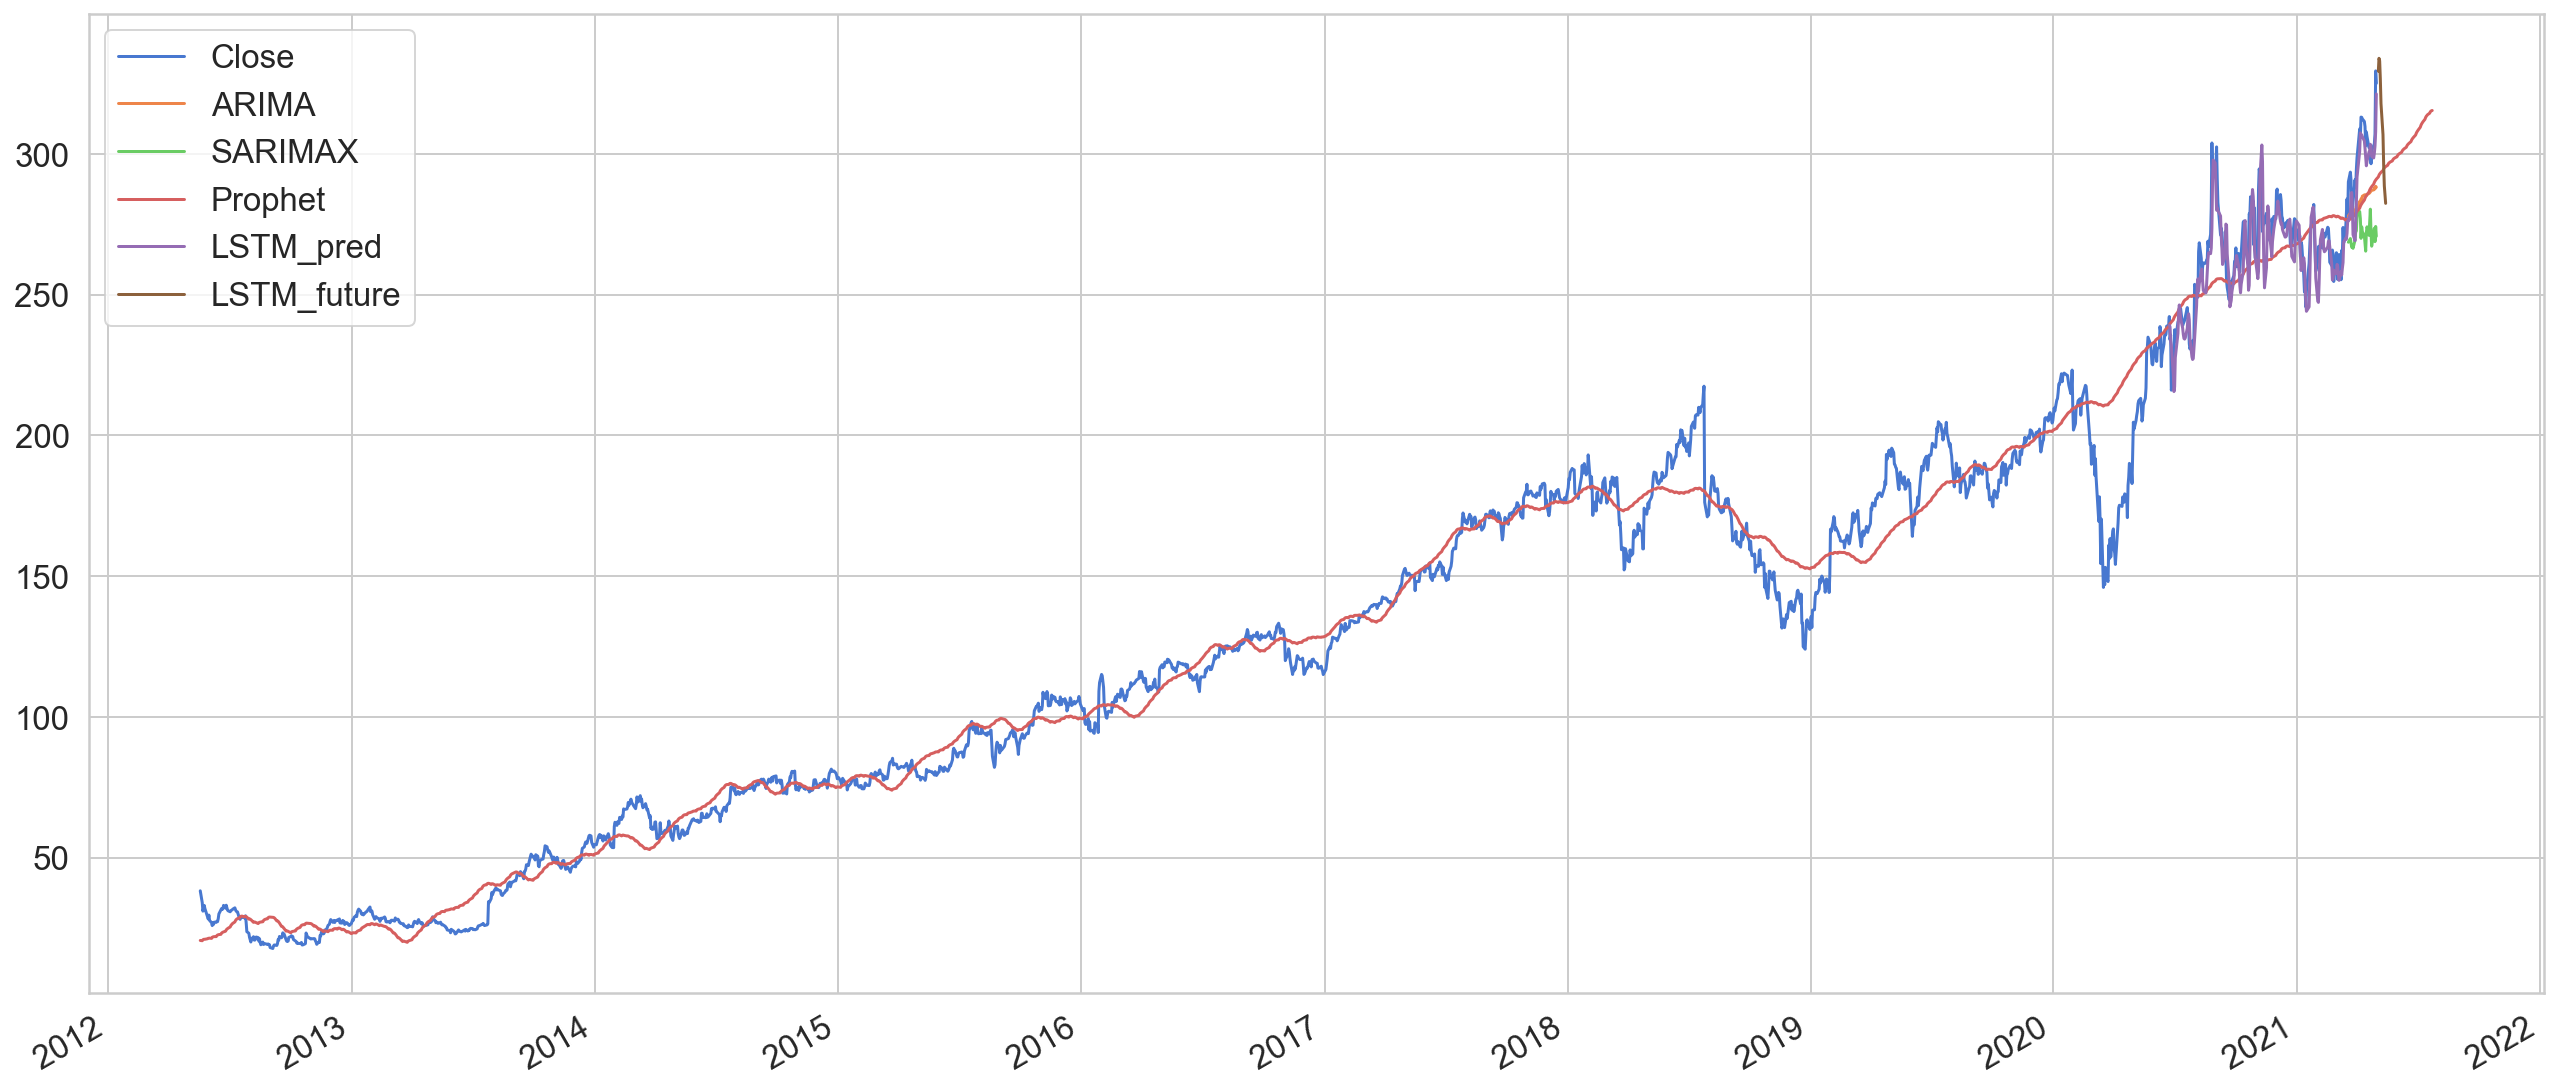

In [115]:
results_df.plot()
plt.show()

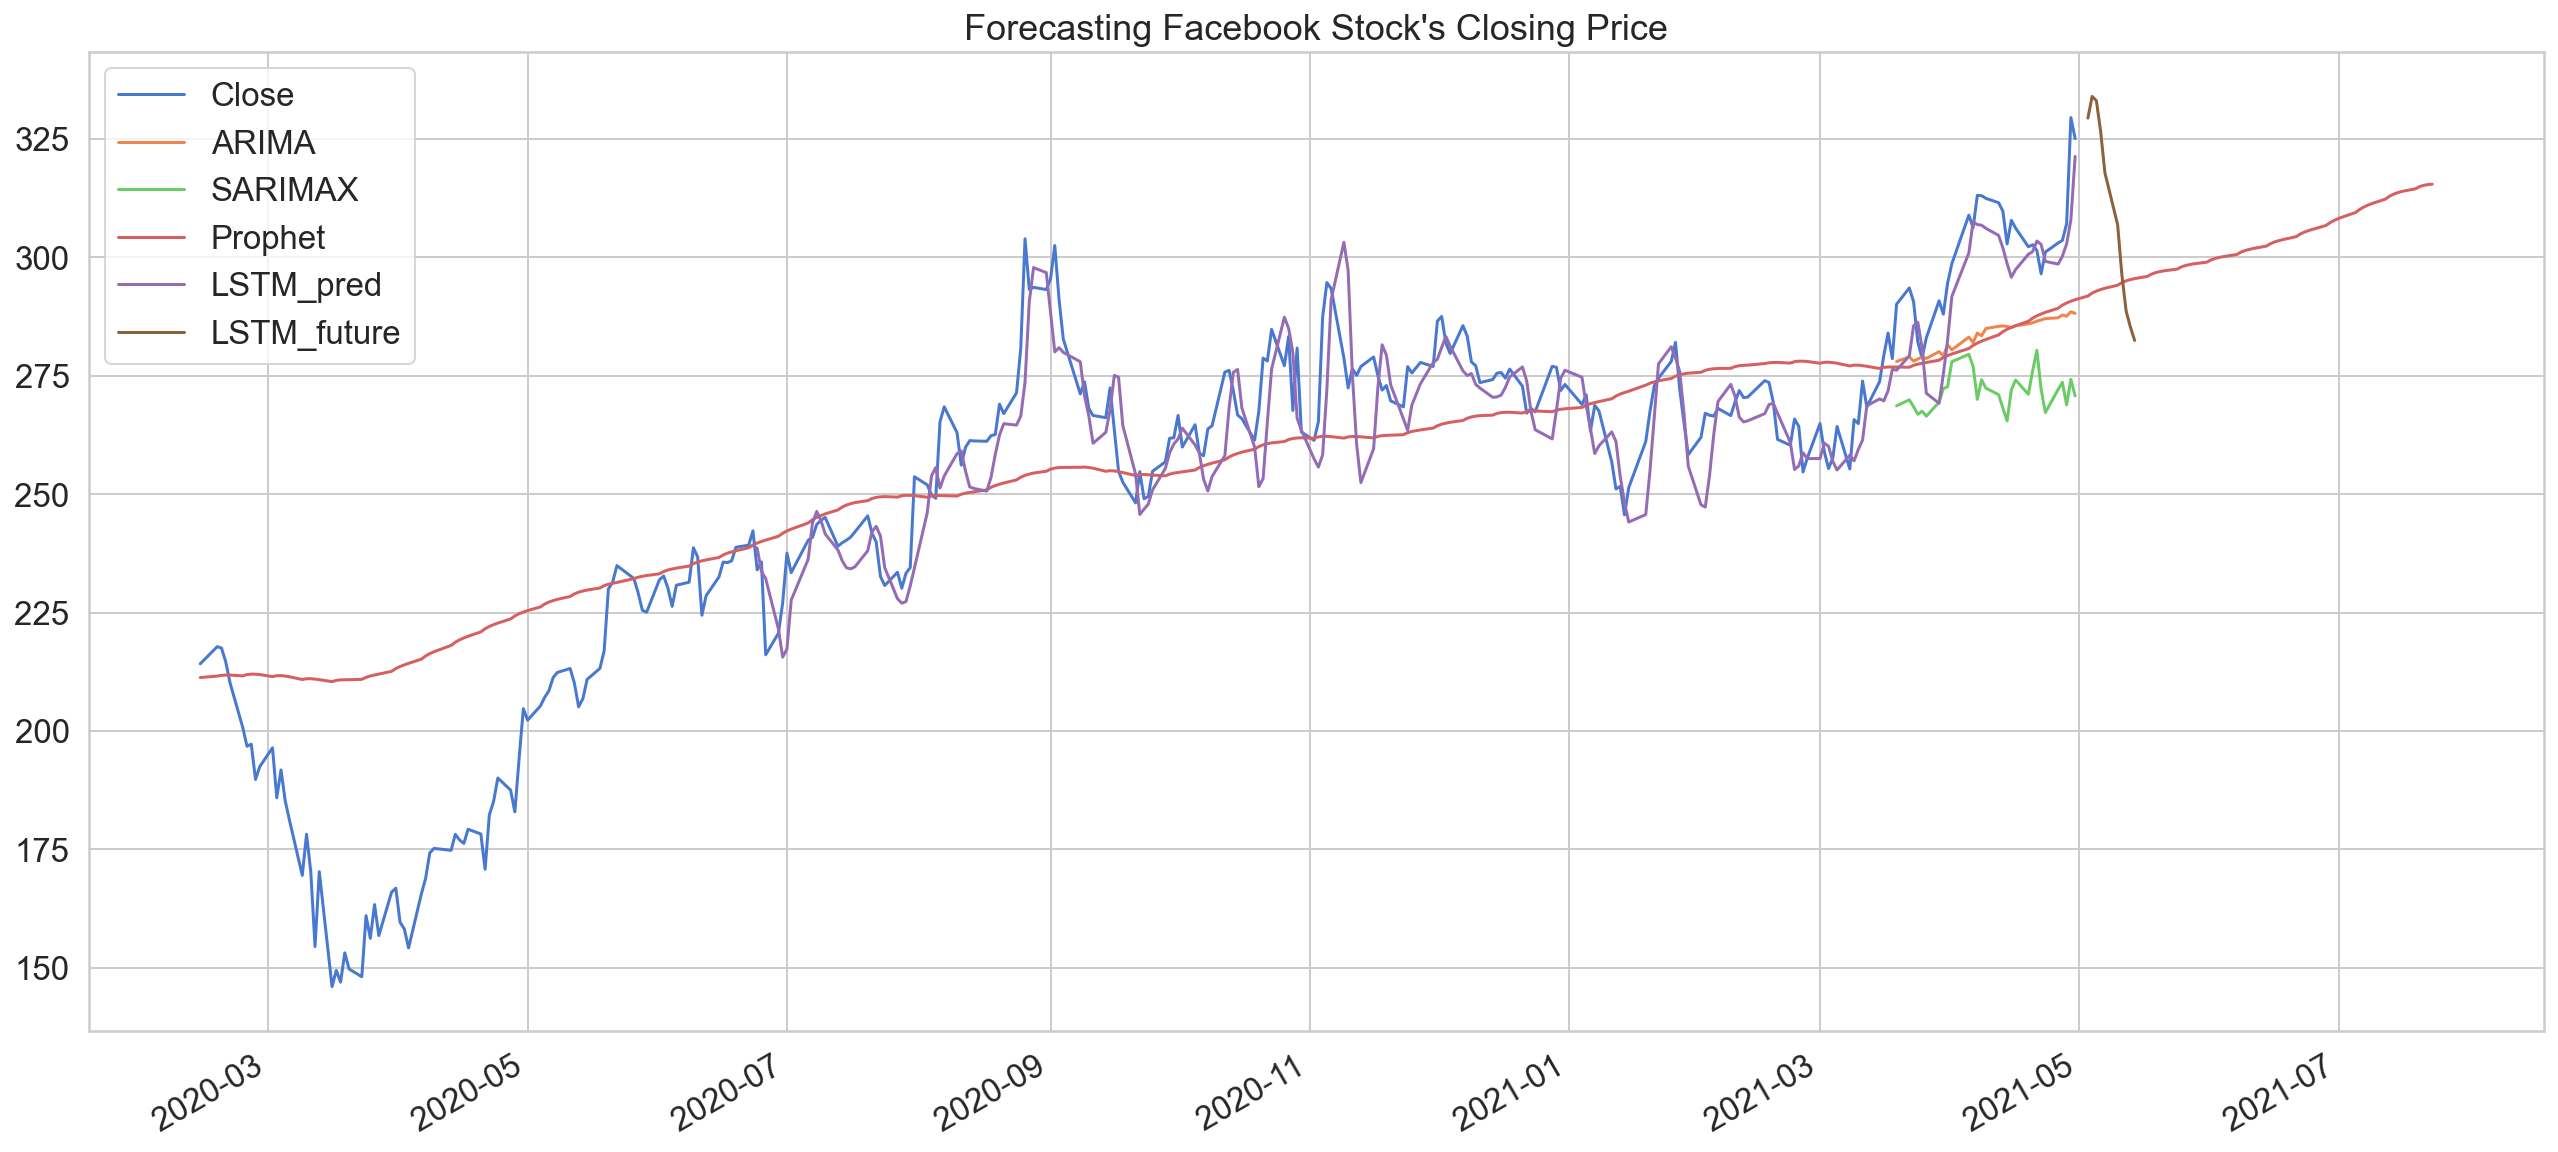

In [116]:
results_df.iloc[-365:].plot(title="Forecasting Facebook Stock's Closing Price")
plt.show()

In [117]:
results_df.to_csv('full_results.csv')